In [1]:
#########################
######### ROUTINE TO PLOT THE SEASONAL MEAN OF ANY VARIABLE OVER AN ALREADY 
######### SELECTED REGION.
#########################

import cartopy

import cartopy.feature as cfeat
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import xarray as xr
import numpy as np

import datetime
import pandas

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
#########################
######### DICTIONARIES DEFINITION 
#########################

Range_MLD = {
    'Mar' : {
        'vmin' : 160, 
        'vmax' : 1800},
    'Sep' : {
        'vmin' : 18, 
        'vmax' : 180},
}


#Colorbar parameters
color_bar = {
    'cmap' : 'YlGnBu',
    'orientation' : 'vertical',
    'title_cbr' : 'depth [m]'
}


# Coordinates for small regions. Position in
# (lon, lat): (rigth,  letf), (south, north),
# and title for an eventual ploting title.
reg = {
    'lab': {
        'lon' : (-55, -51),
        'lat' : (56, 59),
        'name' : 'Labrador Sea'
    },
    'irm': {
        'lon' : (-39, -35),
        'lat' : (58, 61),
        'name' : 'Irminger Sea'
    },
    'gul': {
        'lon' : (-57, -53),
        'lat' : (34, 38),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-20, -16),
        'lat' : (50, 53),
        'name' : 'North East Sea'
    }
}



# Coordinates for large regions. Position in
# (lon, lat): (rigth,  letf), (south, north),
# and title for an eventual ploting title.
reg_ext = {
    'lab': {
        'lon' : (-60, -30),
        'lat' : (50, 65),
        'name' : 'Labrador and Irminger Seas'
    },
    'gul': {
        'lon' : (-75, -45),
        'lat' : (30, 45),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-30, -5),
        'lat' : (45, 60),
        'name' : 'North East Sea'
    },
    'noa':{
        'lon' : (-90, 50),
        'lat' : (10, 85),
        'name' : 'North Atlantic Ocean'
    }
}


## This dictionary is for the higher variability of the region
reg_var = {
    'lab': {
        'lon' : (-60, -30),
        'lat' : (50, 65),
        'name' : 'Labrador and Irminger Seas'
    },
    'gul': {
        'lon' : (-60, -45),
        'lat' : (37, 45),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-30, -5),
        'lat' : (45, 60),
        'name' : 'North East Sea'
    },
    'noa':{
        'lon' : (-90, 50),
        'lat' : (10, 85),
        'name' : 'North Atlantic Ocean'
    }
}


points = {
    'gul': {
        'lon': -60., 
        'lat': 35.
    },
    'lab': {
        'lon': -50., 
        'lat': 55.
    },
    'noe': {
        'lon': -17.5, 
        'lat': 52.5}
}


In [3]:
def Grid(data_set):
    """
        Grid is a function that creates a rectangular grid using as x a longitude
        array and for y a latitude array.
        
        Parameters:
        ------------
            
        data_set : DataArray
            Is the dataset from which we will plot the histogram.
        
        Output:
        -------
        (x, y) : n-arrays
            Arrays that correspond for each (lon,lat) point
    """
    x = data_set.longitude
    y = data_set.latitude
    
    x, y = np.meshgrid(x, y)
    return(x, y)


## Function to crop the dataset

def Crops(d_set, lon1=None, lon2=None, lat1=None, lat2=None, reg_name=None, dic=None):
    """
        Crops is a function that takes a data set and crops it into smaller
        region, using as parameters the values given by a variable dictionary.
        
        Parameters:
        ------------
          
        d_set : DataArray
            Dataset to be cropped
        
        lon : float
            Tuple for the longitude limits of the region selected.
        
        lat : float
            Tuple for the latitude limits of the region selected.
      
        reg_name : string
            Key value that identifies the region to obtain
        
        dic : dictionary
            Is the dictionary from which we extract the coordinates
        
        Output:
        -------
        new_ds : DataArray
            New data array corresponding to the region stated by 'coord'
    """
    
    
    if dic :
        lon1, lon2 = dic[reg_name]['lon']
        lat1, lat2 = dic[reg_name]['lat']
        name_fig = dic[reg_name]['name']
    
    new_ds = d_set.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2))

    return(new_ds)


def Histogram(data_set, n_bins, xlims=None, ylims=None, i=None, ax=None, alpha=0.85, 
              htype='bar', label=None, normed=None, lw=None):
    """
        Histogram is a function that helps to make a semi-log histogram plot
        of a dataset. The 'y' axis is logaritmic, and the 'x' axis is linear.
        The function accepts a dataset with any kind of values and it filters the
        nan values.
        
        Parameters:
        ------------
            
        data_set : DataArray
            Is the dataset from which we will plot the histogram.
        
        n_bins : integer
            Number of bins for the histogram.
            
        xlims : tuple, float
            The limits for the x axis
        
        ylims : tuple, float
            The limits for the y axis
        
        i : integer
            Is the time step we are working on. if None, it returns the
            complete array's histogram
            
        ax : axes.Axes object or array of Axes objects
            axes of the n-th sub plot
        
        Output:
        -------
        Plot, Fig.
    """
    ## Creation of an array to save all values for the histogram
    ### This could be done in a faster way!!
    
    a = []
    
    if i == None:
        for j in range(len(data_set[:])):
            a = np.append(a, data_set[j])
    else:
        for j in range(len(data_set[i])):
            a = np.append(a, data_set[i, j])

    ##Taking away the nan values
    a2 = No_nan(a)
    ran = (xlims)
        
    if not ax:
        ax = plt.gca()
    
    ax.hist(a2, n_bins, range=ran, histtype=htype, label=label, alpha=alpha, 
            normed=normed, linewidth=lw)
    ax.set_yscale("log", nonposy='clip')
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_xlabel('MLD (m)', fontsize=10)
    ax.set_ylabel('# of occuped grid points', fontsize=10)
    ax.grid(True)
    
    
    
def No_nan(a):
    """
        No_nan is a function that helps to filter an array from nan values.
        
        Parameters:
        ------------
        a : Numpy Array
            Is the array we want to filter
        
        Output:
        -------
        a2 : Numpy Arrray
            Array with no nan values in it
    """
    nan_array = np.isnan(a)
    not_nan_array = ~ nan_array
    a2 = a[not_nan_array]
    
    return(a2)


def Masking(data_set, cond):
    """
        Maskin is a function that makes a mask of an array depending on the 
        entering condition. The condition is evaluated over finite numbers.
        At the final, the mask is appended in the original DataArray as a 
        new coordinate.
        
        Parameters:
        ------------
        data_set : DataArray
            Is the array we want to make the mask of.
            
        cond : array
            Codition to meet. 


        Output:
        -------
        data_set : Numpy Arrray
            Array with new coordinates 'mask'
    """
    
    mask = 1 * np.ones((data_set.dims['latitude'], data_set.dims['longitude'])) * np.isfinite(cond)  
    data_set.coords['mask'] = (('latitude', 'longitude'), mask)
    return(data_set)

In [4]:
def Year_sel(data_set, yr):
    """
        Year_sel slects an specific year from a dataset.  
        
        Parameters:
        ------------
            
        data_set : DataArray
            Array from we extract the year.
        
        yr : int
            Number of the year we want 
        
        Output:
        ------------
        y : dataArray
            DataArray containing only the data corresponding to yr
            
    """
    cond = data_set.time.dt.year.isin([yr])
    y = data_set.sel(time=cond)
    
    return(y)

def Point_sel(data_set, lon, lat, isel=True):
    """
        Point_sel selects a point given the latitude and longitude, or the 
        index of the array. The default function is using isel. If sel() wants
        to be used, the nearest method is used to select the point.
        
        
        Parameters:
        ------------
            
        data_set : DataArray
            Array from we extract the year.
        
        lon : float
            Coordinate for longitude.
        
        lat : float
            Coordinate for latitude.
        
        Output:
        ------------
        p : dataArray
            DataArray containing only the data corresponding to (lon, lat)
            
    """
    if isel:
        p = data_set.isel(longitude=lon, latitude=lat)
    else:
        p = data_set.sel(longitude=lon, latitude=lat, method='nearest')
    
    return(p)
    

In [71]:
###############################################################################
###########         MAIN PROGRAM
###############################################################################


## Opening datasets
dir_1 = '../../data_ARMOR/'
fl_n1 = 'ARMOR_*.nc'

c_armor = xr.open_mfdataset(dir_1 + fl_n1)
c_armor = Masking(c_armor, c_armor.to[0,25])


## Taking just MLD from the datasets

## Climatology
month_a = c_armor.groupby('time.month').mean('time')


# Let's see the Gulf Stream: Mean and Standard deviation

In [72]:
#Crops(d_set, lon1=None, lon2=None, lat1=None, lat2=None, reg_name=None, dic=None):
gulf = Crops(c_armor, lon1=None, lon2=None, lat1=None, lat2=None, reg_name='gul', dic=reg_ext)

## Here erasing c_armor, porque muy grande
del c_armor

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<IPython.core.display.Javascript object>


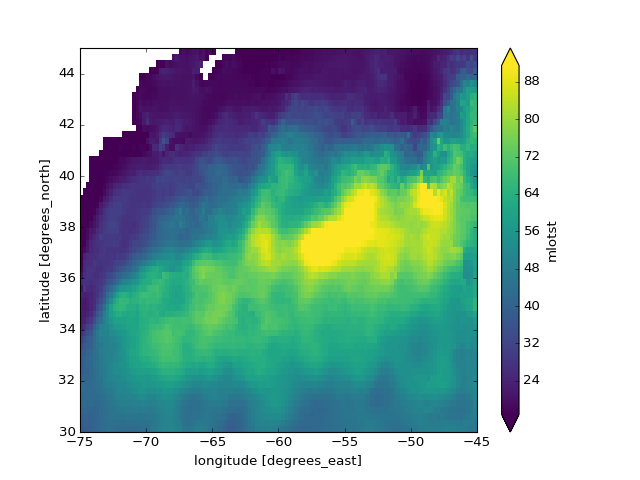

In [141]:
%matplotlib notebook

plt.close()
gulf.mlotst.mean(dim='time').plot(robust=True)


/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<IPython.core.display.Javascript object>


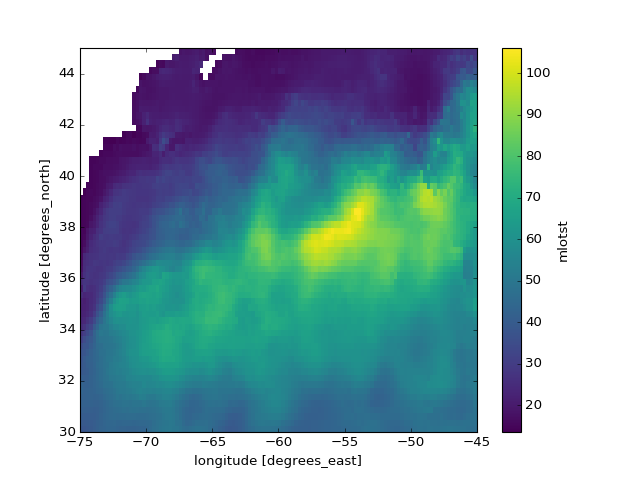

array(106.04063, dtype=float32)

In [146]:
%matplotlib notebook

plt.close()
gulf.mlotst.mean(dim='time').plot(robust=False)
gulf.mlotst.mean(dim='time').max(skipna=True).values


In [135]:
gulf.mlotst.std(dim='time').max(skipna=True).values

/usr/local/lib/python3.5/dist-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


array(288.92053, dtype=float32)

/usr/local/lib/python3.5/dist-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<IPython.core.display.Javascript object>


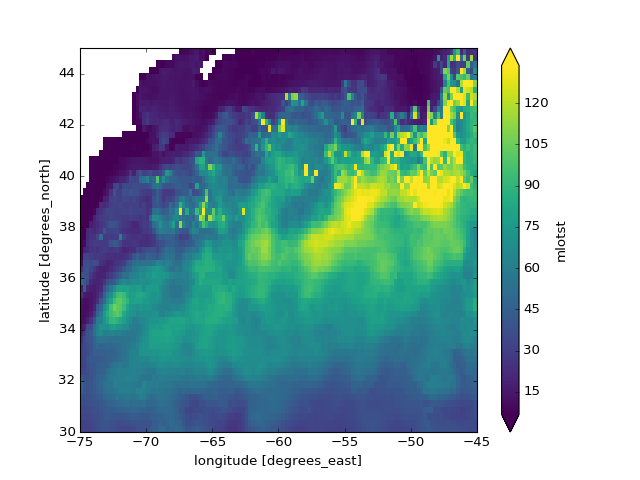

array(288.92053, dtype=float32)

In [143]:
%matplotlib notebook
plt.close()
gulf.mlotst.std(dim='time').plot(robust=True)
gulf.mlotst.std(dim='time').max(skipna=True).values

/usr/local/lib/python3.5/dist-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<IPython.core.display.Javascript object>


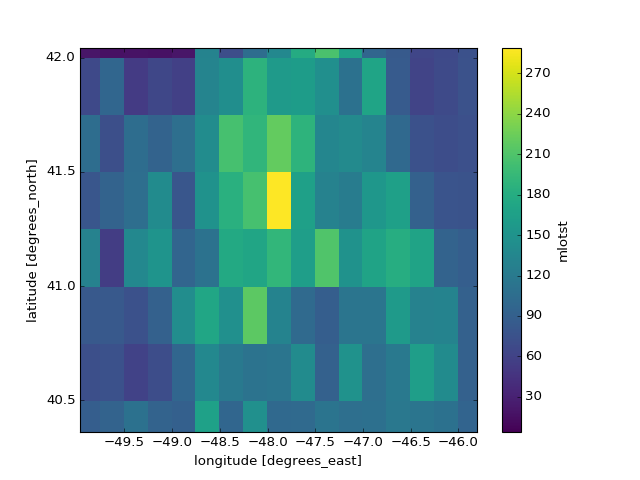

array(288.92053, dtype=float32)

In [147]:
%matplotlib notebook
plt.close()
gulf.mlotst.std(dim='time').plot(robust=False)
gulf.mlotst.std(dim='time').max(skipna=True).values

In [95]:
plt.close()
small = gulf.mlotst.sel(longitude=slice(-50, -49.5), latitude=slice(42.5, 43.))
s = small.longitude[0].values
s.max()

-49.875

<IPython.core.display.Javascript object>


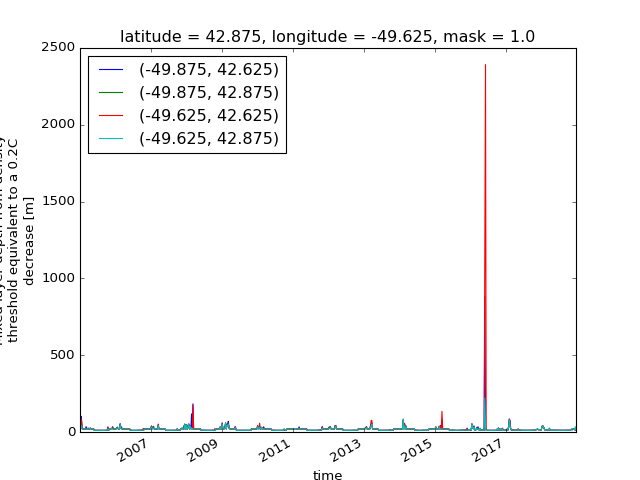

In [97]:
plt.close()
for i in range(2):
    for j in range(2):
        lo = small.longitude[i].values.max()
        la = small.latitude[j].values.max()
        small.isel(longitude=i, latitude=j).plot(label=(lo,la))
        plt.legend(loc='upper left')

In [160]:
plt.close()
small = gulf.mlotst.sel(longitude=slice(-48, -47.2), latitude=slice(41., 41.6))
small.latitude

<xarray.DataArray 'latitude' (latitude: 2)>
array([41.125, 41.375], dtype=float32)
Coordinates:
  * latitude  (latitude) float32 41.125 41.375
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    axis:           Y

<IPython.core.display.Javascript object>


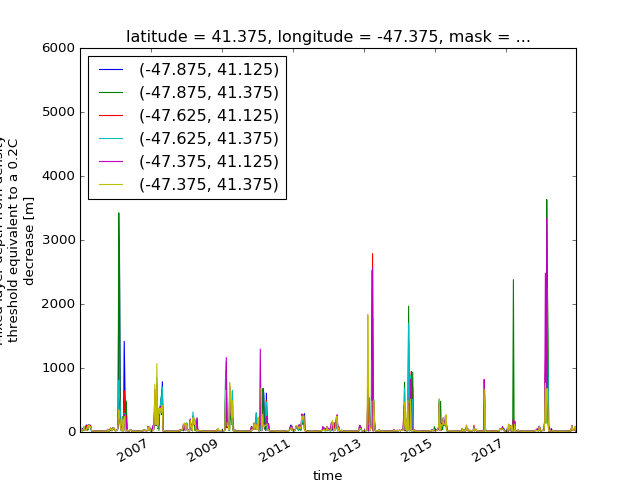

In [161]:
plt.close()
for i in range(3):
    for j in range(2):
        lo = small.longitude[i].values.max()
        la = small.latitude[j].values.max()
        small.isel(longitude=i, latitude=j).plot(label=(lo,la))
        plt.legend(loc='upper left')
        plt.ylim(0, 6000)

In [66]:
m = small.mean(dim='time').values
s = small.std(dim='time').values

print(m)
print(s)

[[21.02547  19.555103 19.931322 19.45608 ]
 [20.434118 23.399687 19.808475 18.307251]
 [19.249138 22.546257 18.676638 17.949612]
 [17.25133  17.19859  16.88174  17.059412]]
[[ 20.226328   17.233847   17.495539   17.152624 ]
 [ 49.91571   125.58643    52.52506    14.33996  ]
 [ 34.28643    98.6133     29.902851   14.274856 ]
 [  8.898633   11.035605    7.7892933   7.9643183]]


<IPython.core.display.Javascript object>


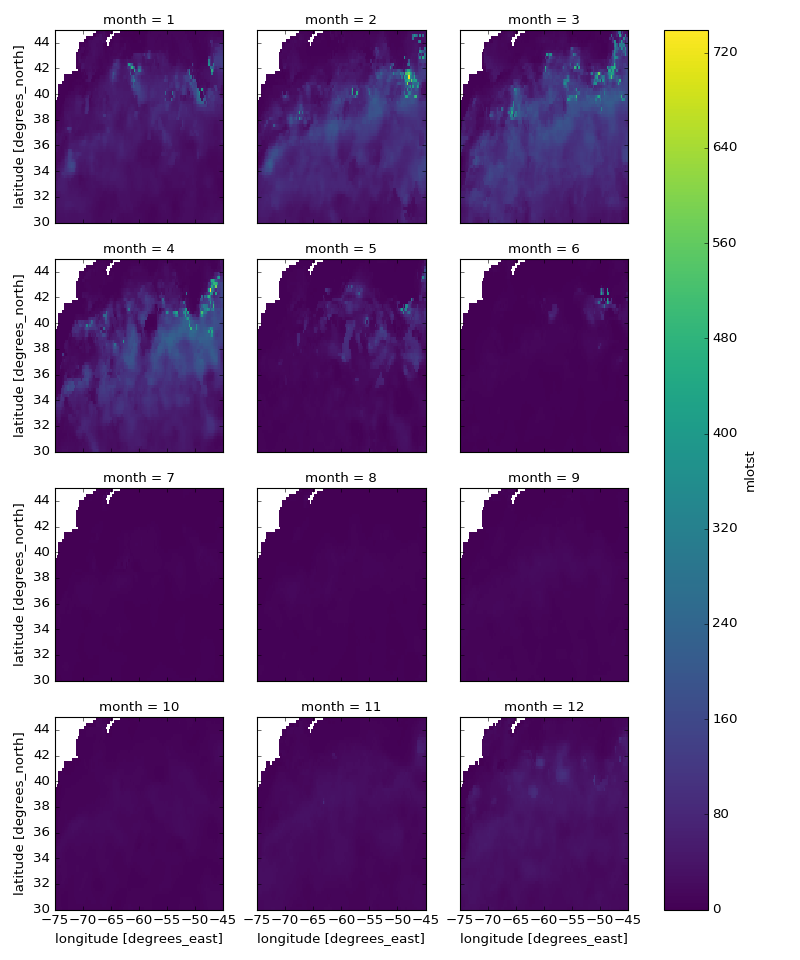

/usr/local/lib/python3.5/dist-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [126]:
plt.close()
std_w = gulf.groupby('time.month').std(dim='time')

std_w.mlotst.plot(col='month', col_wrap=3, robust=False)


## Maximumn standard deviation in the month

In [131]:
std_w.mlotst.groupby('month').max(skipna=True).values

/usr/local/lib/python3.5/dist-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


array([473.56717 , 731.12317 , 571.8027  , 739.1463  , 403.2376  ,
       432.6726  ,  20.172165,  17.264017,  23.856302,  25.049454,
        93.38265 , 110.43842 ], dtype=float32)

In [132]:
## Maximum in the general std
mm = gulf.mlotst.std(dim='time', skipna=True)
mm.max(skipna=True).values

/usr/local/lib/python3.5/dist-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


array(288.92053, dtype=float32)

## Making a mask 

In [119]:
percents = gulf.mlotst.std(dim='time').reduce(np.nanpercentile, 
                                              q=98, dim=('longitude', 'latitude'))

/usr/local/lib/python3.5/dist-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [120]:
percents.values

array(133.73160919)

In [121]:
mask_i = 1 * np.ones((gulf.dims['latitude'], 
                    gulf.dims['longitude'])) * (gulf.mlotst.std(dim='time') >= percents) 
gulf.coords['mask_i'] = (('latitude', 'longitude'), mask_i)



/usr/local/lib/python3.5/dist-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<IPython.core.display.Javascript object>


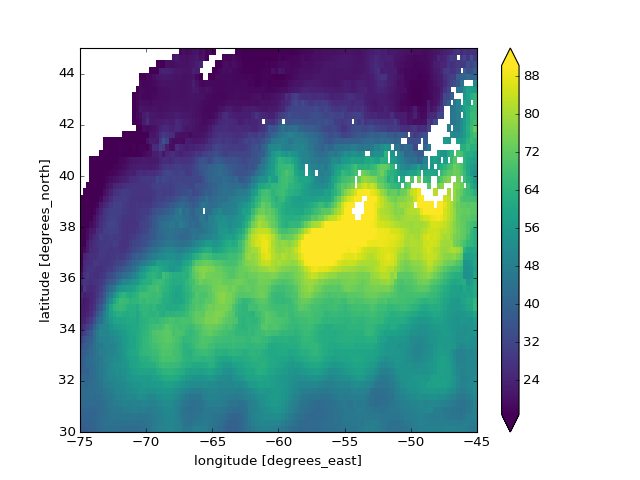

In [164]:
plt.close()
gulf.mlotst.where(gulf.mask_i==0).mean(dim='time').plot(robust=True)

In [18]:
gulf.mlotst[1].where(gulf.mask_i==0).max(skipna=True).values


array(474.09998, dtype=float32)

In [123]:
opt =  gulf.mask_i==0 #std_w.mlotst<=percents


In [124]:
gulf.mlotst.where(opt).groupby('time.month').mean('time').max(skipna=True).values

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


array(299.15482, dtype=float32)

<IPython.core.display.Javascript object>


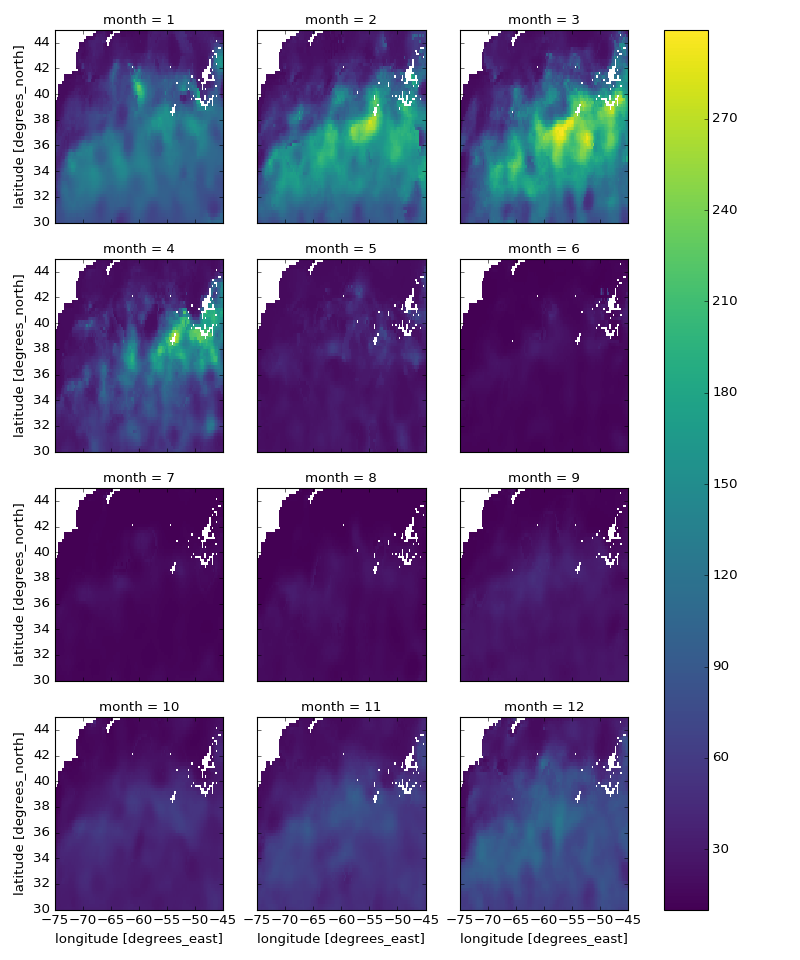

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [125]:
plt.close()

opt =  gulf.mask_i==0 #std_w.mlotst<=percents

gulf.mlotst.where(opt).groupby('time.month').mean('time').plot(col='month', col_wrap=3, robust=False)

## Using ISAS, mean and standar deviation

In [102]:
dir_2 = '/net/alpha/exports/sciences/data/LPO_ISAS/ANA_ISAS15/fld2D/'
fl_n2 = 'ISAS15_DM_2006_2015_MLDS.nc'

In [104]:
isas = xr.open_dataset(dir_2+fl_n2)

gulf_i = Crops(d_set=isas, dic=reg_ext, reg_name='gul')

/usr/local/lib/python3.5/dist-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<IPython.core.display.Javascript object>


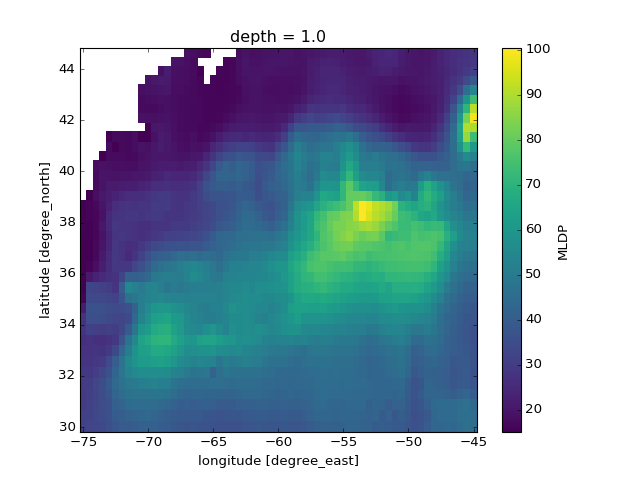

<xarray.DataArray 'MLDP' ()>
array(100.416664, dtype=float32)

In [137]:
plt.close()
gulf_i.MLDP.mean(dim='time').plot(robust=False)
gulf_i.MLDP.mean(dim='time').max(skipna=True)

/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


<IPython.core.display.Javascript object>


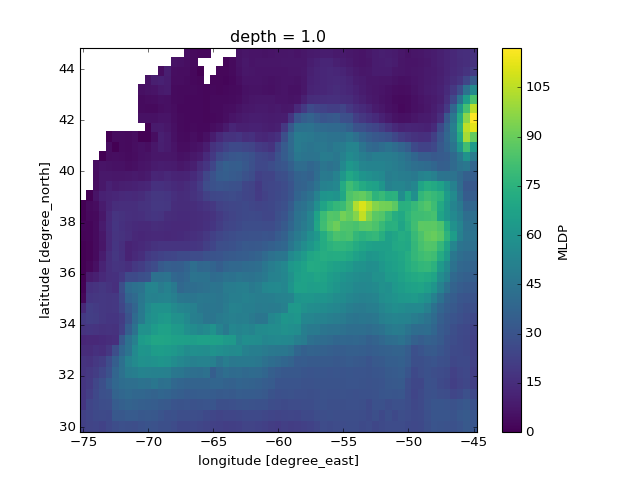

<xarray.DataArray 'MLDP' ()>
array(116.978096, dtype=float32)

In [138]:
plt.close()
gulf_i.MLDP.std(dim='time').plot(robust=False)
gulf_i.MLDP.std(dim='time').max(skipna=True)

/usr/local/lib/python3.5/dist-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<IPython.core.display.Javascript object>


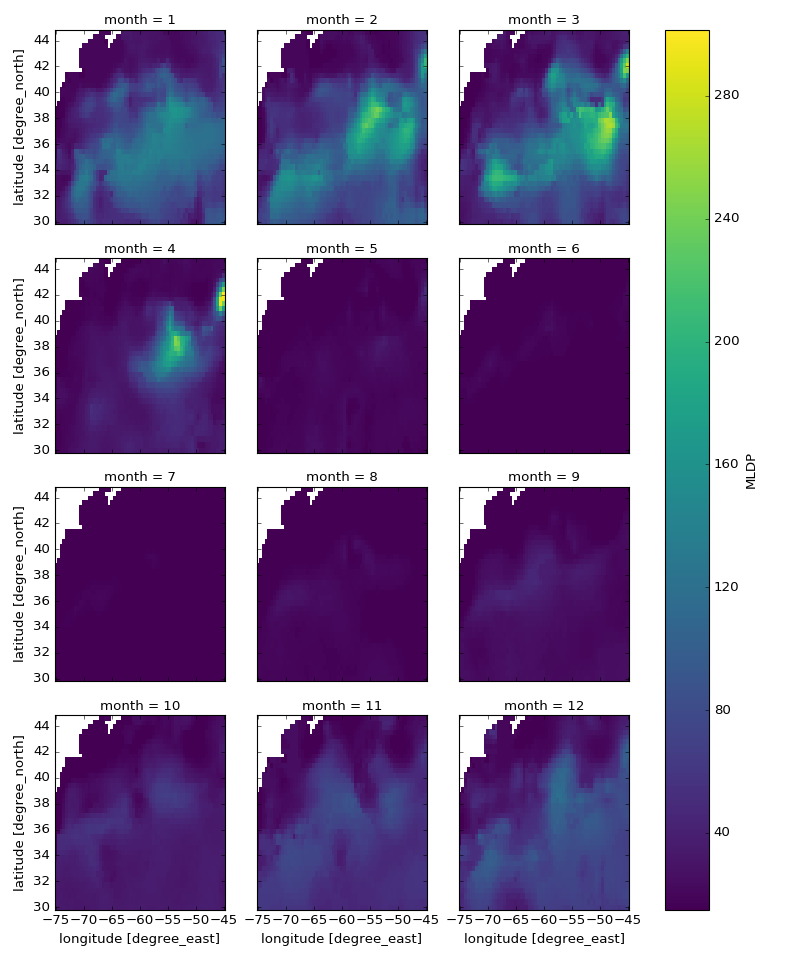

In [116]:
plt.close()

gulf_i.MLDP.groupby('time.month').mean(dim='time').plot(col='month', col_wrap=3, robust=False)